#**NFT PRICE PREDICTION**

### IMPORTING LIBRARIES

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###READING THE DATASET 
data of "bored apes" NFT collected using the OpenSea API

In [ ]:
df_raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/opensea/bored_apes.csv', parse_dates=['SaleDate']).rename(columns={'index': 'TokenId'})
df = df_raw.loc[(df_raw['USDPrice'] != 0) & (~df_raw['LastSalePrice'].isna())]
df = df.sort_values(['SaleDate']).reset_index(level=0, drop=True)  # sort by sale date and time
df.head()

,TokenId,LastSalePrice,Background,BackgroundRarity,Earring,EarringRarity,Fur,FurRarity,Eyes,EyesRarity,Mouth,MouthRarity,Clothes,ClothesRarity,Hat,HatRarity,LastSaleToken,NumberOfSales,SaleDate,USDPrice
0,742,0.12,Purple,0.1291,NaN,NaN,Cheetah,0.0406,Sunglasses,0.0352,Bored Kazoo,0.0074,Tanktop,0.0235,Sea Captain's Hat,0.0304,Ether,1.0,2021-05-01 02:36:07.954644,491.3940
1,832,0.12,Blue,0.1242,NaN,NaN,Golden Brown,0.0778,Sunglasses,0.0352,Grin Gold Grill,0.0091,Caveman Pelt,0.0163,Bandana Blue,0.0089,Ether,1.0,2021-05-01 02:42:39.319928,491.3940
2,1026,0.09,Orange,0.1273,NaN,NaN,Golden Brown,0.0778,Bored,0.1714,Bored Unshaven Cigarette,0.0438,Leather Punk Jacket,0.0153,NaN,NaN,Ether,1.0,2021-05-01 04:26:03.610832,368.5455
3,1150,0.50,Purple,0.1291,NaN,NaN,Dark Brown,0.1352,Closed,0.0710,Bored Unshaven,0.1551,Vietnam Jacket,0.0224,Laurel Wreath,0.0072,Ether,1.0,2021-05-01 05:01:06.871720,2047.4750
4,1685,0.18,Aquamarine,0.1266,Silver Hoop,0.0882,Zombie,0.0302,Crazy,0.0407,Bored Unshaven,0.1551,NaN,NaN,Beanie,0.0578,Ether,1.0,2021-05-01 06:32:25.020302,737.0910


In [ ]:
df.columns

Index(['TokenId', 'LastSalePrice', 'Background', 'BackgroundRarity', 'Earring',
       'EarringRarity', 'Fur', 'FurRarity', 'Eyes', 'EyesRarity', 'Mouth',
       'MouthRarity', 'Clothes', 'ClothesRarity', 'Hat', 'HatRarity',
       'LastSaleToken', 'NumberOfSales', 'SaleDate', 'USDPrice'],
      dtype='object')

### EXPLORATORY DATA ANALYSIS

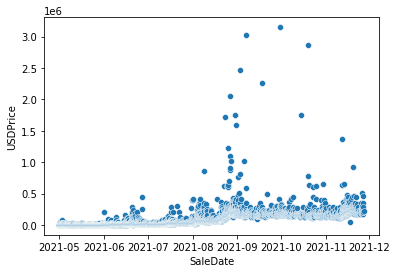

In [ ]:
sns.scatterplot(x='SaleDate', y='USDPrice', data=df)

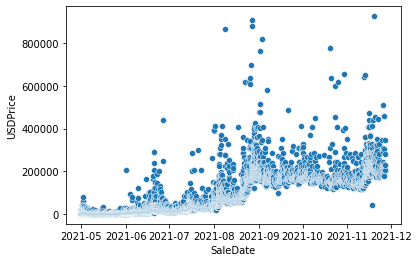

In [ ]:
ts = df.groupby('SaleDate').agg({'USDPrice': 'mean'})
ts_outrm = ts.loc[ts['USDPrice'] < 10e5]
sns.scatterplot(x='SaleDate', y='USDPrice', data=ts_outrm)

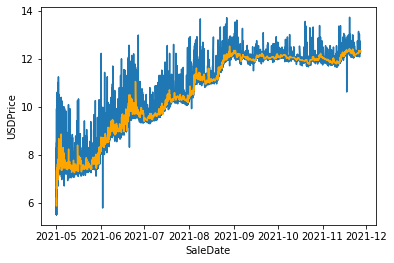

In [ ]:
log_price = np.log(ts_outrm['USDPrice'])
sns.lineplot(x='SaleDate', y=log_price, data=ts_outrm)
rolling_median = log_price.rolling(window=14).median()
sns.lineplot(x=ts_outrm.index, y=rolling_median, color='orange')

### DATA PREPROCESSING

Dealing with outliers

In [ ]:
df['LogUSDPrice'] = np.log(df['USDPrice'])
mean = df['LogUSDPrice'].ewm(span=14).mean()  # exponentially weighted moving average with 14 point window
std = df['LogUSDPrice'].ewm(span=14).std()

mean_plus_std = mean + 1.7*std
# mean_minus_std = mean - 2*std

# is_outlier = (df['LogUSDPrice'] > mean_plus_std) | (df['LogUSDPrice'] < mean_minus_std)
is_outlier = df['LogUSDPrice'] > mean_plus_std
df['Outlier'] = 1
df.loc[is_outlier, 'Outlier']=-1

In [ ]:
dfo, dfi = df[is_outlier].copy(), df[~is_outlier].copy()
dfs = dfo, dfi
for data in dfs:
    rolling_median = data['LogUSDPrice'].rolling(window=7, min_periods=1).median()
    ewm = data['LogUSDPrice'].ewm(span=14).mean()
    data['LogUSDPriceEWM'] = (rolling_median + ewm) / 2
    # Percentage Extension from the Exponential Weighted Moving Average
    data['PctExtensionEWM'] = data.apply(lambda x: (x['LogUSDPrice'] - x['LogUSDPriceEWM']) / x['LogUSDPriceEWM'], axis=1)

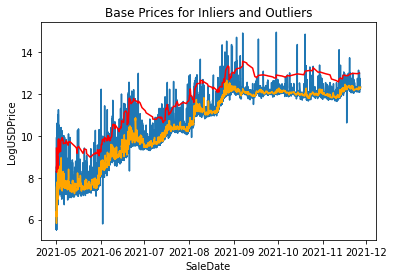

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(x='SaleDate', y='LogUSDPrice', data=df)
sns.lineplot(x='SaleDate', y='LogUSDPriceEWM', color='orange', data=dfi)
sns.lineplot(x='SaleDate', y='LogUSDPriceEWM', color='red', data=dfo)
ax.set_title('Base Prices for Inliers and Outliers')
plt.show()

Handling Missing Values

In [ ]:
rarity_cols = [c for c in df.columns if 'Rarity' in c]  #numeric rarity related cols
# clean up na's in rarity cols
def fill_trait_na(col) -> float:
    fill_value = 1 - col.dropna().unique().sum()
    return fill_value

for data in dfs:
    data[rarity_cols] = data[rarity_cols].apply(lambda x: x.fillna(fill_trait_na(x)))

In [ ]:
#Change NaNs to None. This way it represents an actual category (not having a hat for example).
traits = ['Background', 'Earring', 'Fur', 'Eyes', 'Mouth', 'Clothes', 'Hat']
for data in dfs:
    data[traits] = data[traits].fillna('None')

Text(0.5, 1.0, 'Distribution of Extension from EWM Outliers')

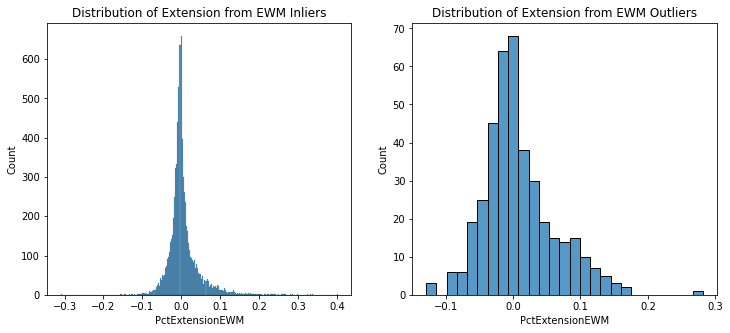

In [ ]:
#plotting inliers and outliers to check for normalization of data
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
sns.histplot(dfi['PctExtensionEWM'], ax=ax1)
ax1.set_title('Distribution of Extension from EWM Inliers')
sns.histplot(dfo['PctExtensionEWM'], ax=ax2)
ax2.set_title('Distribution of Extension from EWM Outliers')

To implement a decision rule that rightfully detects whether an NFT is an outlier or not based on features instead of price, I decided to check for the traits which were most famous and checked with the rarity column for set of traits

In [ ]:
def has_two_less_1pct(row, cols):
    """Retruns true if the NFT has at least two traits with rarities less than 1%"""
    rarity = row[cols].values
    n = len(rarity[np.where(rarity < 0.01)])
    if n> 1:
        return 1
    return 0

def has_rare_clothes_or_fur(row):
    """Return true if the NFT has clothes or fur with a rarity of less than 1%"""
    if row['ClothesRarity'] < 0.01 or row['FurRarity'] < 0.01:
        return 1
    return 0

from collections import Counter
def find_matches(row, categories):
    traits = row[categories].values
    keywords = []
    for trait in traits:
        #print(trait)
        split = trait.split(' ')
        for word in split:
            keywords.append(word)

    if 'None' in keywords:
        keywords.remove('None')
    counts = Counter(keywords)
    most_common = counts.most_common(1)
    matches = most_common[0][1] - 1
    if matches:
        return 1
    return 0

for data in dfs:
    data['HasTwoLess1Pct'] = data.apply(lambda x: has_two_less_1pct(x, rarity_cols), axis=1)
    data['HasRareClothesOrFur'] = data.apply(has_rare_clothes_or_fur, axis=1)
    data['HasMatches'] = data.apply(lambda x: find_matches(x, traits), axis=1)

In [ ]:
for data in dfs:
    data.loc[(data['HasTwoLess1Pct']==1) | (data['HasRareClothesOrFur']==1), 'OutlierRule'] = -1
    data['OutlierRule'] = data['OutlierRule'].fillna(1)

so now we have an `OutlierRule` column which contains -1 if any of the rule rarity is below 1% else it has 1. We are doing this to try and include rarity in predicting prices

### Encoding Categorical Features

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
categorical_feature_cols = [
    'Background',
    'Earring',
    'Mouth',
    'Clothes',
    'Hat',
    'Fur',
    'Eyes',
]
clf_features = ['HasTwoLess1Pct', 'HasRareClothesOrFur', 'HasMatches']

In [ ]:
# encode outlier data
enc = OneHotEncoder(handle_unknown='ignore')

# regression encoded dataframe
enc_df = pd.DataFrame(enc.fit_transform(dfo[categorical_feature_cols]).toarray())
enc_df.index = list(enc_df.index)  # convert index to int64 index

# add labels
enc_df.columns = enc.get_feature_names_out()

# merge and drop
dfp = dfo.reset_index(drop=True).merge(enc_df.reset_index(drop=True), left_index=True, right_index=True)
dfo = dfp.drop(columns=categorical_feature_cols)

In [ ]:
# encode inlier data
enc = OneHotEncoder(handle_unknown='ignore')

# regression encoded dataframe
enc_df = pd.DataFrame(enc.fit_transform(dfi[categorical_feature_cols]).toarray())

# add labels
enc_df.columns = enc.get_feature_names_out()

# merge and drop
dfp = dfi.reset_index(drop=True).merge(enc_df.reset_index(drop=True), left_index=True, right_index=True)
dfi = dfp.drop(columns=categorical_feature_cols)

In [ ]:
print(dfi.shape)

(7992, 192)


Now both the inlier dataFrame `dfi` as well as the outlier dataFrame `dfo` have been one-hot encoded (the traits) and added as additional columns to the original dataframe. This is shown by the shape function indicating that there are 192 columns because of the one hot encoded columns

In [ ]:
df = pd.concat([dfi, dfo])
#storing all the one_hot encoded data column names along with the matches and no of sales of set nft
features = [feature for feature in df.columns if '_' in feature]
features.extend(['HasMatches', 'NumberOfSales'])
print(features[-10:])

['Eyes_Robot', 'Eyes_Sad', 'Eyes_Scumbag', 'Eyes_Sleepy', 'Eyes_Sunglasses', 'Eyes_Wide Eyed', 'Eyes_X Eyes', 'Eyes_Zombie', 'HasMatches', 'NumberOfSales']


### Preparing data for regression

In [ ]:
from sklearn.model_selection import train_test_split,cross_validate

In [ ]:
X = df.loc[:, features+['OutlierRule', 'Outlier']]
#taking target variable as the modified USD price as we are trying to use traits to predict selling price
y = df['PctExtensionEWM']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
#inliers of the decision rule made w.r.t trait rarity
X_train_in = X_train[X_train['Outlier']==1].drop(columns=['OutlierRule', 'Outlier'])
y_train_in = y_train[X_train['Outlier']==1]

In [ ]:
#outliers of the decision rule made w.r.t trait rarity
X_train_out = X_train[X_train['Outlier']==-1].drop(columns=['OutlierRule', 'Outlier'])
y_train_out = y_train[X_train['Outlier']==-1]
display(X_train_out)

,Background_Aquamarine,Background_Army Green,Background_Blue,Background_Gray,Background_New Punk Blue,Background_Orange,Background_Purple,Background_Yellow,Earring_Cross,Earring_Diamond Stud,...,Eyes_Robot,Eyes_Sad,Eyes_Scumbag,Eyes_Sleepy,Eyes_Sunglasses,Eyes_Wide Eyed,Eyes_X Eyes,Eyes_Zombie,HasMatches,NumberOfSales
201,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,2.0
161,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0
228,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0
39,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0
205,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,3.0
162,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0
14,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0
234,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0


### Implementing a Regressor

In [ ]:
from sklearn.ensemble import VotingRegressor
#so this is an ensemble learning model which combines all the regressors as a stack
#According to stack overflow it does regression using all the models and picks the averaged out -
# majority prediction which sounded like a better variant in comparison to simple GridSearchCV so I decided to use this
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, HuberRegressor, LassoCV

In [ ]:
estimators = [('randomforest', RandomForestRegressor(random_state=42, n_estimators=200)),
              ('linear', LassoCV(random_state=42)),
              ('huber', HuberRegressor(epsilon=2, max_iter=1000))]

In [ ]:
vreg_in, vreg_out = VotingRegressor(estimators),  VotingRegressor(estimators)

In [ ]:
#implemented cross validation for training set
cross_validate(vreg_in, X_train_in, y_train_in, cv=3,
               scoring=('neg_mean_squared_error'),
               return_train_score=True)

{'fit_time': array([23.25505638, 20.44590735, 17.30365658]),
 'score_time': array([0.29451752, 0.18528128, 0.1943996 ]),
 'test_score': array([-0.00084108, -0.00086722, -0.00082498]),
 'train_score': array([-0.00048788, -0.00046956, -0.00048151])}

In [ ]:
vreg_in.fit(X_train_in, y_train_in)
vreg_out.fit(X_train_out, y_train_out)

VotingRegressor(estimators=[('randomforest',
                             RandomForestRegressor(n_estimators=200,
                                                   random_state=42)),
                            ('linear', LassoCV(random_state=42)),
                            ('huber',
                             HuberRegressor(epsilon=2, max_iter=1000))])

In [ ]:
def predict(X, models: dict):
    #Custom prediction function
    ## So the problem which I realized late into the model was that the regression models take in 173 rows
    ## and the test data has 175 rows -- the 2 rows being the outlier determiners
    ## which i completely forgot to use and blindly tried - vreg_in.predict(X_test)
    ### Anyways this function splits X test data into outliered and inliered
    ### and respectfully runs predict function so that outliered data gets calculated by outlier model vreg_out and inlier by vreg_in
    outliers = X['OutlierRule'] == -1
    X_o = X.loc[outliers].drop(columns=['OutlierRule', 'Outlier'])
    X_i = X.loc[~outliers].drop(columns=['OutlierRule', 'Outlier'])
    y = np.empty(X.shape[0])  # store combined predictions
    
    # predict target values separately accorindg to the two models
    if X_o.shape[0]:
        y_o_pred = models['o'].predict(X_o)
        y[outliers] = y_o_pred
    if X_i.shape[0]:
        y_i_pred = models['i'].predict(X_i)
        y[~outliers] = y_i_pred
    
    return y

In [ ]:
y_actual, y_pred = y_test, predict(X_test, {'o': vreg_out, 'i': vreg_in})
predict_df = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred})
from sklearn import metrics
-metrics.mean_squared_error(y_test, y_pred)

-0.0011067743966976424

In [ ]:
print(y_pred)

[ 0.00077658  0.05498782  0.00474185 ...  0.00075116 -0.0147683
 -0.00397608]


In [ ]:
#printing final result with important columns and predicted price
predicted_merged = df.merge(predict_df, how='left', left_index=True, right_index=True)
predicted_merged = predicted_merged.loc[~predicted_merged['Predicted'].isna()]

cols = predicted_merged.columns[0:]
pm = predicted_merged.loc[:, ['TokenId', 'SaleDate', 'LogUSDPriceEWM', 'Actual', 'Predicted', 'USDPrice', 'PctExtensionEWM']]

#converting back from log price * log price ^ predicted exponent
pm['PredictedUSDPrice'] = np.exp(pm['LogUSDPriceEWM'] * (1 + pm['Predicted']))

pm.sample(10)

,TokenId,SaleDate,LogUSDPriceEWM,Actual,Predicted,USDPrice,PctExtensionEWM,PredictedUSDPrice
585,4950,2021-05-02 10:43:22.512822,7.331432,0.190526,0.053058,6174.960000,0.190526,2253.921804
253,8923,2021-05-01 17:57:50.991544,6.704095,-0.004963,0.132790,571.082343,-0.053186,1986.897630
3698,5662,2021-06-20 15:12:02.665861,10.042150,0.040716,0.014313,34579.776000,0.040716,26526.165931
6711,3701,2021-09-06 09:48:47.309181,12.087582,0.014988,-0.000685,212937.400000,0.014988,176186.441099
183,4482,2021-06-20 13:32:40.680009,11.806548,0.048397,0.063693,237507.100000,0.048397,284514.897162
6000,1954,2021-08-23 13:11:46.041586,11.623994,-0.000916,-0.015116,110563.650000,-0.000916,93740.117710
5169,4664,2021-08-02 16:08:58.340632,10.716524,-0.007416,0.026015,41649.673000,-0.007416,59594.211983
3792,1177,2021-06-21 08:19:22.562350,9.928203,-0.010739,-0.006196,18427.275000,-0.010739,19277.417620
2699,38,2021-06-05 17:58:05.571447,8.648170,0.028273,0.022045,7278.480000,0.028273,6896.866120
2457,7223,2021-06-01 18:15:06.021976,8.559655,-0.031230,-0.015287,3993.140800,-0.031230,4577.010415


In [ ]:
#accuracy measure from 0 to 1
pm['Accuracy'] = 1 - abs(pm['PredictedUSDPrice'] - pm['USDPrice']) / ((pm['PredictedUSDPrice'] + pm['USDPrice']) / 2)
pm.sort_values('Accuracy', ascending=False).tail(10)

,TokenId,SaleDate,LogUSDPriceEWM,Actual,Predicted,USDPrice,PctExtensionEWM,PredictedUSDPrice,Accuracy
18,6833,2021-05-01 22:25:32.729835,8.998379,0.001952,0.173976,8.233280e+03,0.001952,3.871097e+04,-0.298463
672,4749,2021-05-02 16:37:23.040381,7.761045,0.161691,-0.042044,8.233280e+03,0.161691,1.693812e+03,-0.317499
7946,4734,2021-11-22 12:43:00.966301,12.230032,0.038962,0.169217,3.298984e+05,0.038962,1.622643e+06,-0.324166
253,185,2021-08-02 01:02:58.091324,11.947701,-0.004963,0.132790,1.455696e+05,-0.004963,7.548188e+05,-0.353303
66,8350,2021-05-01 09:17:57.379578,6.600820,-0.044125,0.002665,4.075474e+03,0.259350,7.487541e+02,-0.379172
334,3749,2021-09-06 21:02:49.694425,13.574374,-0.060251,-0.025458,3.030263e+06,0.099436,5.561541e+05,-0.379711
113,7318,2021-05-01 10:35:01.916004,6.813188,0.060553,0.191913,6.170843e+02,-0.056975,3.363467e+03,-0.379901
252,4281,2021-08-01 16:34:16.375162,12.241928,-0.030148,0.115779,1.433232e+05,-0.030148,8.553724e+05,-0.425958
6635,7130,2021-09-03 07:07:08.242456,12.233287,0.026311,0.173673,2.835542e+05,0.026311,1.720079e+06,-0.433920
349,2087,2021-09-30 01:29:04.799542,12.913732,-0.022428,-0.011377,3.149017e+06,0.158658,3.503917e+05,-0.599485


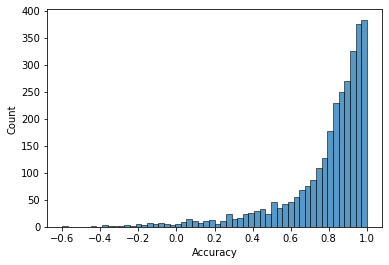

In [ ]:
#plotting how accuracy distribution because summing up the accuracies will not give correct result
fig, ax = plt.subplots()
ax = sns.histplot(pm['Accuracy'])
plt.show()

### Ranking best features based on Random forest

Since I was working with traits instead of time series analysis, I thought It would also help in showing what traits play the biggest role in classifcation i.e have the highest information gain so to say

In [ ]:
X = X_train.drop(columns=['OutlierRule', 'Outlier'])
forest = RandomForestRegressor(n_estimators=200).fit(X, y_train)

In [ ]:
importance = pd.DataFrame({'Importance': forest.feature_importances_}, index=X.columns)
top_importance = importance.sort_values('Importance', ascending=False).head(15)
#descing order of feature importance for classificiation

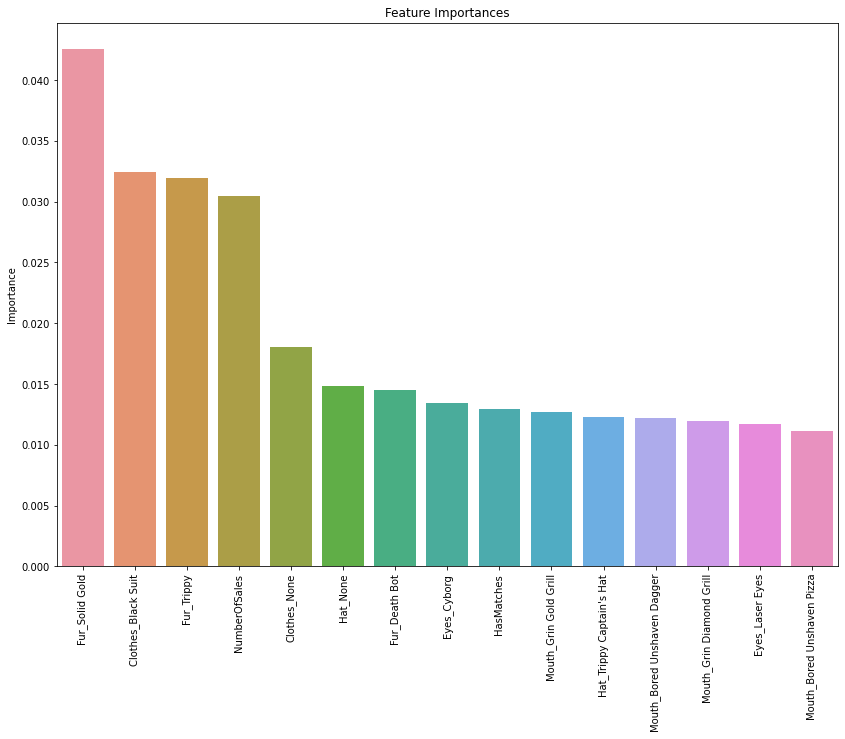

In [ ]:
fig, ax = plt.subplots(figsize=(14,10))
ax = sns.barplot(x=top_importance.index, y='Importance', data=top_importance)
ax.set_title('Feature Importances')
plt.xticks(rotation=90)
plt.show()

## A deep learning approach

In [ ]:
import datetime
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

Preprocessing Date Attribute

In [ ]:
df["SaleDate"] = df["SaleDate"].apply(lambda x: x.timestamp())
df.head()

,TokenId,LastSalePrice,Background,BackgroundRarity,Earring,EarringRarity,Fur,FurRarity,Eyes,EyesRarity,...,Clothes,ClothesRarity,Hat,HatRarity,LastSaleToken,NumberOfSales,SaleDate,USDPrice,LogUSDPrice,Outlier
0,742,0.12,Purple,0.1291,1,1.0000,Cheetah,0.0406,Sunglasses,0.0352,...,Tanktop,0.0235,Sea Captain's Hat,0.0304,Ether,1.0,1.619837e+09,491.3940,6.197246,1
1,832,0.12,Blue,0.1242,1,1.0000,Golden Brown,0.0778,Sunglasses,0.0352,...,Caveman Pelt,0.0163,Bandana Blue,0.0089,Ether,1.0,1.619837e+09,491.3940,6.197246,1
2,1026,0.09,Orange,0.1273,1,1.0000,Golden Brown,0.0778,Bored,0.1714,...,Leather Punk Jacket,0.0153,1,1.0000,Ether,1.0,1.619843e+09,368.5455,5.909564,1
3,1150,0.50,Purple,0.1291,1,1.0000,Dark Brown,0.1352,Closed,0.0710,...,Vietnam Jacket,0.0224,Laurel Wreath,0.0072,Ether,1.0,1.619845e+09,2047.4750,7.624363,1
4,1685,0.18,Aquamarine,0.1266,Silver Hoop,0.0882,Zombie,0.0302,Crazy,0.0407,...,1,1.0000,Beanie,0.0578,Ether,1.0,1.619851e+09,737.0910,6.602711,1


Categorical Variable Handling

In [ ]:
df = df.apply(lambda x: pd.factorize(x)[0] if x.name in ['Background', 'Earring', 'Fur', 'Eyes', 'Mouth', 'Clothes', 'Hat', 'LastSaleToken', ] else x)
df

,TokenId,LastSalePrice,Background,BackgroundRarity,Earring,EarringRarity,Fur,FurRarity,Eyes,EyesRarity,...,Clothes,ClothesRarity,Hat,HatRarity,LastSaleToken,NumberOfSales,SaleDate,USDPrice,LogUSDPrice,Outlier
0,742,0.1200,0,0.1291,0,1.0000,0,0.0406,0,0.0352,...,0,0.0235,0,0.0304,0,1.0,1.619837e+09,491.39400,6.197246,1
1,832,0.1200,1,0.1242,0,1.0000,1,0.0778,0,0.0352,...,1,0.0163,1,0.0089,0,1.0,1.619837e+09,491.39400,6.197246,1
2,1026,0.0900,2,0.1273,0,1.0000,1,0.0778,1,0.1714,...,2,0.0153,2,1.0000,0,1.0,1.619843e+09,368.54550,5.909564,1
3,1150,0.5000,0,0.1291,0,1.0000,2,0.1352,2,0.0710,...,3,0.0224,3,0.0072,0,1.0,1.619845e+09,2047.47500,7.624363,1
4,1685,0.1800,3,0.1266,1,0.0882,3,0.0302,3,0.0407,...,4,1.0000,4,0.0578,0,1.0,1.619851e+09,737.09100,6.602711,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8382,387,51.6969,1,0.1242,0,1.0000,6,0.0626,14,0.0549,...,24,0.0140,21,0.0182,0,7.0,1.637953e+09,209041.58484,12.250288,1
8383,8645,50.0000,3,0.1266,0,1.0000,0,0.0406,1,0.1714,...,4,1.0000,24,0.0377,0,7.0,1.637959e+09,205505.50000,12.233228,1
8384,2263,69.0000,1,0.1242,0,1.0000,2,0.1352,5,0.0233,...,12,0.0206,2,1.0000,0,2.0,1.637965e+09,282551.55000,12.551616,1
8385,7737,49.8800,2,0.1273,2,0.0823,8,0.1229,11,0.0751,...,2,0.0153,27,0.0157,0,5.0,1.637967e+09,205338.00320,12.232413,1


SPLITTING DATA INTO TRAIN AND TEST SET

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.loc[:, ~df.columns.isin(['LogUSDPrice', 'USDPrice'])], df.LogUSDPrice, test_size=0.2)

Linear Regression

In [ ]:
df.isnull().any()
linreg = LinearRegression()
linreg.fit(x_train, y_train)

LinearRegression()

In [ ]:
mse = mean_squared_error(y_test, linreg.predict(x_test))
np.sqrt(mse)

0.7360032594840547

In [ ]:
linreg.score(x_test,y_test)

0.8401676903767751

### Linear regression results
**Accuracy:** 84.17%
**MSE:** 0.716

##USING AN LSTM

In [ ]:
#Scaling before using lstm
sc = MinMaxScaler(feature_range = (-1, 1))
x_train = sc.fit_transform(x_train)
x_train

array([[ 0.21777422, -0.99994437, -0.14285714, ..., -0.71428571,
        -0.31274189,  1.        ],
       [-0.0306245 , -0.9999938 , -1.        , ..., -1.        ,
        -0.70645015,  1.        ],
       [-0.48558847, -0.99999447, -0.42857143, ..., -1.        ,
        -0.70838483,  1.        ],
       ...,
       [ 0.82966373, -0.9999855 ,  0.42857143, ..., -0.57142857,
        -0.63631083,  1.        ],
       [ 0.42574059, -0.99995185,  1.        , ..., -0.57142857,
        -0.28081833,  1.        ],
       [-0.37109688, -0.99999955, -0.71428571, ..., -1.        ,
        -0.99825382,  1.        ]])

In [ ]:
#Splitting into train and test
x_train, y_train = np.asarray(x_train).astype('float32'), np.asarray(y_train).astype('float32')
y_train = np.reshape(y_train, (-1, 1))
y_train = sc.fit_transform(y_train)
y_train

array([[ 0.02623439],
       [-0.4265834 ],
       [-0.4500531 ],
       ...,
       [-0.25472832],
       [-0.00414777],
       [-0.852836  ]], dtype=float32)

In [ ]:
x_train, y_train = np.asarray(x_train).astype('float32'), np.asarray(y_train).astype('float32')

In [ ]:
#training the model
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics= ["mean_squared_error"])
regressor.fit(x_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
210/210 [==============================] - 17s 44ms/step - loss: 0.1261 - mean_squared_error: 0.1261
Epoch 2/50
210/210 [==============================] - 10s 47ms/step - loss: 0.0611 - mean_squared_error: 0.0611
Epoch 3/50
210/210 [==============================] - 10s 46ms/step - loss: 0.0452 - mean_squared_error: 0.0452
Epoch 4/50
210/210 [==============================] - 9s 44ms/step - loss: 0.0231 - mean_squared_error: 0.0231
Epoch 5/50
210/210 [==============================] - 9s 43ms/step - loss: 0.0184 - mean_squared_error: 0.0184
Epoch 6/50
210/210 [==============================] - 15s 73ms/step - loss: 0.0176 - mean_squared_error: 0.0176
Epoch 7/50
210/210 [==============================] - 13s 63ms/step - loss: 0.0168 - mean_squared_error: 0.0168
Epoch 8/50
210/210 [==============================] - 9s 44ms/step - loss: 0.0163 - mean_squared_error: 0.0163
Epoch 9/50
210/210 [==============================] - 9s 44ms/step - loss: 0.0159 - mean_squared_error: 0.0

In [ ]:
x_test = StandardScaler().fit_transform(x_test)
x_test = np.asarray(x_test).astype('float64')
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test

array([[[ 1.15958878],
        [-0.46544565],
        [ 0.65774424],
        ...,
        [ 0.19085031],
        [-0.65449756],
        [ 0.22955961]],

       [[-0.72518428],
        [ 0.9187094 ],
        [ 0.65774424],
        ...,
        [ 0.19085031],
        [ 1.07098072],
        [ 0.22955961]],

       [[-0.27742246],
        [ 0.99329363],
        [-1.51317401],
        ...,
        [ 1.2819809 ],
        [ 2.2887406 ],
        [ 0.22955961]],

       ...,

       [[ 1.38983597],
        [-0.48618891],
        [-0.64480671],
        ...,
        [ 0.7364156 ],
        [-0.55888264],
        [ 0.22955961]],

       [[ 1.19142019],
        [ 0.84412518],
        [ 0.65774424],
        ...,
        [-0.35471498],
        [ 0.44644028],
        [ 0.22955961]],

       [[-0.49847391],
        [-0.49228987],
        [-0.64480671],
        ...,
        [ 0.19085031],
        [-1.13166376],
        [ 0.22955961]]])

### Validtion

In [ ]:
y_pred = regressor.predict(x_test)
y_pred

array([[-0.09071846],
       [ 0.53216064],
       [ 0.5388546 ],
       ...,
       [ 0.17008457],
       [ 0.51095307],
       [-0.25136223]], dtype=float32)

In [ ]:
y_pred = sc.inverse_transform(y_pred)
y_pred

array([[ 9.786843 ],
       [12.720623 ],
       [12.7521515],
       ...,
       [11.015233 ],
       [12.620734 ],
       [ 9.030207 ]], dtype=float32)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)

1.451503786144241

### LTM RESULTS
**MSE:** 1.451